# Tutorial 3: Evaluating the trained model on the test data

### Outline

* Imports, including library code from previous steps
* Loading the trained model using hyperparameters and weights file
* Setting up the datapipe for the test data
* Some functions for "undoing/inverting" the ETL pipeline (aka recovering spatiotemporal relations)
* Running the trained model in eval mode
* Some basic metrics and analysis

## Setup and configuration

As you might expect, we start with some standard imports. Here we will be also importing our ability to create LSTM based models and load experiments which fit our narrow focus via the `src.models` and `src.utils` modules which you can find included with the tutorial. Additionally we are using the `src.datapipes` module which comes from earlier as well. Finally, we set the device and data type as usual.

In [1]:
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings

from tqdm.autonotebook import tqdm
from matplotlib.colors import PowerNorm
from src.models import create_lstm_model
from src.utils import load_experiment
from src.datapipes import (
    make_data_pipeline, merge_data, select_region,
    scale_means, scale_stds
)

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float16

/tmp/ipykernel_4285/2583463801.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Loading the setup from our saved experiment

With the defaults out of the way, we can prove how nice it is to have even some minimal MLOps infrastructure set up via the `save_experiment` and `load_experiment` functions by simply loading up the previously saved experiment. We then instantiate an equivalent model structure and load the trained model into it. We are then ready to start thinking about how we can apply this model to new data!

In [2]:
config_file = '../experiments/tutorial/tutorial.yml'
config = load_experiment(config_file)
model = create_lstm_model(**config['model_config'])
model.load_state_dict(torch.load(config['weights_file'], map_location=DEVICE))
model.to(DTYPE).to(DEVICE)
model.eval()

Sequential(
  (0): LSTM(5, 128, batch_first=True)
  (1): LSTMOutput()
  (2): Linear(in_features=128, out_features=1, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
)

## Data plumbing for model inference

We expect you're getting excited at this point to see how the trained model performs, but the unfortunate reality of using deep-learning models means that there is often a rift between training and application data workflows. In our case it's not to onerous, but it does require a little bit of work to be most efficient. As always, we just want to open the data up as a first step, and we can reuse previous data processing functions to get there.

In [3]:
ds = merge_data()
test_data = select_region(
    ds.sel(time=config['data_config']['test_period']),
    config['data_config']['regions']
)

Beyond that, we don't wan't to filter out missing data because that would mean we have ragged arrays that need complex logic to reconstruct. Instead we can just fill missing data. On one hand, this might seem like a hack simply to reduce the number of lines of code, but on the other is actually a nice optimization because of how fast these types of trained models can run compared to actually solving differential equations. That is, it's easier to run a forward pass on some irrelevant data than it is to activiely filter out the missing regions.

In [4]:
true_mask = test_data['mask'].copy()
# Make sure to make sure nans are not in the mask
true_mask = true_mask.fillna(0)
test_data = test_data.fillna(1.0)
test_data['mask'].values[:] = 1.0
test_data = test_data.fillna(1.0)

Now, with the "filled" data, we want to make sure that we record the actual dimensions of the data as a tuple of `(lat, lon, time)` so that we can reconstruct things later.

In [5]:
actual_shape = (
    len(test_data['lat']),
    len(test_data['lon']),
    config['data_config']['output_sequence_length']
)

Now we can record the dimensions that we'll iterate over in place of the ones that we used at train time. What we are doing here is simply setting the `batch_dims` keyword that will go into the `make_data_pipeline` function that we developed in the `datapipes` module. Effectively all this says is to run the full domain on every forward pass of the network.

In [6]:
config['data_config']['batch_dims'] = {
    'lat': len(test_data['lat']),
    'lon': len(test_data['lon'])
}

And finally, we make the data pipeline with our same old `make_data_pipeline` function. We set a few extra parameters like `min_samples=0` so we don't filter anywhere out, `preload=True` so we load the data automatically to save computational cost, and `filter_mask=False` to include data outside of the masked region in order to make spatiotemporally complete predictions. The rest of the configuration comes from what we recorded in the `config`.

In [7]:
pipe = make_data_pipeline(
    ds=test_data, 
    min_samples=0, 
    preload=True,
    filter_mask=False,
    **config['data_config']
)

## Running the model in forward/inference mode

Given this, we are ready to actually run our trained model on the testing dataset. For this we'll loop over the new `pipe` object. For every element in the data pipe we can simply transfer it onto the `DEVICE` and run it through the model. In the process we have specified `with torch.no_grad()` which ensures that we do not run the backwards pass on the model, saving computation. We also make sure to transfer the predictions back onto the CPU from whatever `DEVICE` they were run on and finally reshape everything back into the correct shape, which basically unflattens things so that the spatial relations are recovered.

In [8]:
predictions = []
for i, (x, y) in tqdm(enumerate(pipe)):
    x = x.to(DTYPE).to(DEVICE)
    with torch.no_grad():
        yhat = model(x).cpu().float()
    yhat = yhat.reshape(actual_shape)
    predictions.append(yhat)

0it [00:00, ?it/s]

## Putting the data back together
With the above cell we've done most of the work, but it's often convenient to repackage the resulting predictions from a stack of numpy arrays into an xarray Dataset so that we can easily locate the data in time/space coordinates that are easily interpreted by humans. To do so we can simply make use of the "coordinates" from the truth/reference dataset from ERA5.

In [9]:
start_time = config['data_config']['input_overlap']['time'] 
swe_true = test_data['swe'].isel(time=slice(start_time, -7))

swe_pred = xr.DataArray(
    torch.concat(predictions, dim=2).squeeze().cpu(),
    dims=('lat', 'lon', 'time'), coords = swe_true.coords
) 

Finally, we need to undo our scaling from earlier. We know that we used a "standardization" method to subtract of the mean and divide by the standard deviation of the cubed root of the SWE for training. Ideally this would be recorded by your MLOps framework, but for our narrow use case, we can just undo this by hand here. What comes out is our overall SWE predictions for the test period!

In [10]:
target_var = config['data_config']['output_vars'][0]
mu = scale_means[target_var]
sig = scale_stds[target_var]
swe_pred = np.power((swe_pred * sig) +mu, 3.0)
swe_pred

<xarray.DataArray (lat: 65, lon: 100, time: 2220)>
array([[[ 4.92740762e-03,  4.23133883e-03,  5.05575629e-03, ...,
          3.72598697e-03,  3.65601723e-03,  4.27942177e-03],
        [ 4.99130692e-03,  4.07989615e-03,  4.82212473e-03, ...,
          3.58692899e-03,  3.44301780e-03,  4.03332245e-03],
        [ 5.03421191e-03,  3.99631972e-03,  4.74932610e-03, ...,
          3.25451464e-03,  2.99626252e-03,  3.56979400e-03],
        ...,
        [ 1.60430150e-03,  1.56448614e-03,  1.57933876e-03, ...,
          2.00094208e-02,  2.29498101e-02,  2.30683115e-02],
        [ 1.59428508e-03,  1.55463631e-03,  1.58431044e-03, ...,
          1.99554871e-02,  2.27728201e-02,  2.33663480e-02],
        [ 1.51082349e-03,  1.42104902e-03,  1.43964485e-03, ...,
          2.18442237e-02,  2.47704067e-02,  2.53347742e-02]],

       [[ 3.52719548e-03,  2.93578472e-03,  3.65601723e-03, ...,
          2.95082714e-03,  2.60376579e-03,  2.99626252e-03],
        [ 3.47652626e-03,  2.63158852e-03,  3.21446774e-03, ...,
          2.82459280e-03,  2.49443589e-03,  2.91331708e-03],
        [ 3.31113708e-03,  2.36213340e-03,  2.91331708e-03, ...,
          2.42107490e-03,  2.09369790e-03,  2.56240048e-03],
...
        [-2.84040077e-12, -4.97982626e-15,  2.19286056e-04, ...,
          7.53456989e-05,  1.46649778e-04,  1.18136431e-03],
        [-2.97749022e-11, -2.86487510e-13,  1.11254820e-04, ...,
         -1.16756716e-16,  1.68456609e-05,  7.73541629e-04],
        [-5.95609997e-11, -1.36953273e-11,  1.24764483e-05, ...,
         -1.99205663e-11,  1.34765287e-07,  3.88985776e-04]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-3.30078787e-12, -9.30640620e-13,  6.65647676e-05, ...,
          4.62244934e-05,  1.16415322e-04,  1.02510962e-03],
        [-3.50011747e-11, -5.90239001e-12,  2.98078958e-05, ...,
         -7.15490175e-14,  1.20865880e-05,  7.04713764e-04],
        [-7.79891707e-11, -4.16594475e-11,  3.92901711e-07, ...,
         -3.50011747e-11,  1.45519152e-11,  3.19443643e-04]]])
Coordinates:
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 34.75 34.5 34.25 34.0
  * lon      (lon) float32 230.2 230.5 230.8 231.0 ... 254.2 254.5 254.8 255.0
  * time     (time) datetime64[ns] 2008-11-26 2008-11-27 ... 2014-12-24

## Getting to the analysis and quantifying model performance

At this point we've assembled all of the predictions and reference data into similar data formats and all that's left for us to do is some analysis. Model analysis very problem and domain specific, but we will cover some basic analytics on our model here. First, if you have applied your model to the `WNA`, or Western North America region, you will see we've picked out some individual regions to look at individual timeseries on the spatial averages. These include major portions of prominent mountain ranges such as the Southern Rocky Mountains, Northern Cascade Mountains, and Central Sierra Nevada Mountains.

First, looking at the Southern Rockies we see our model performs quite well in both timing and magnitude! That's quite exciting given we've spent very little actual time training the model.

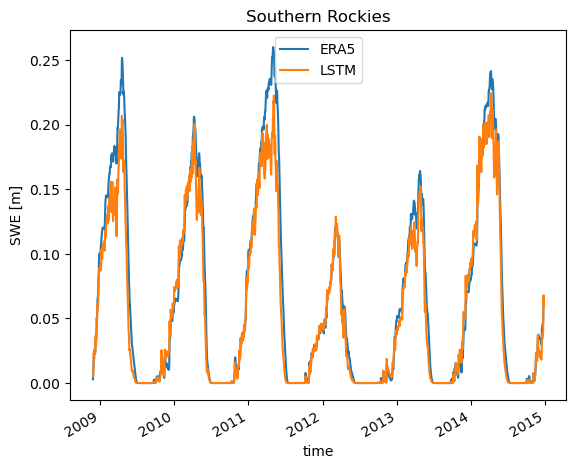

In [11]:
loc = {'lat': slice(40, 38), 'lon': slice(252, 254), }
swe_true.sel(**loc).mean(dim=['lat', 'lon']).plot(label='ERA5')
swe_pred.sel(**loc).mean(dim=['lat', 'lon']).plot(label='LSTM')
plt.title('Southern Rockies')
plt.ylabel('SWE [m]')
plt.legend()

As for the Northern Cascades, we see good agreement in the timing, but a bit of underprediction. You may note that these values are quite a bit higher than the Southern Rockies, and this is part of the reason our model does not capture the magnitude as well. LSTMs, and deep learning models generally, tend to do worse on the extreme values and here is no different. If you trained the model further these would probably be captured better. Still, this is a very good looking model.

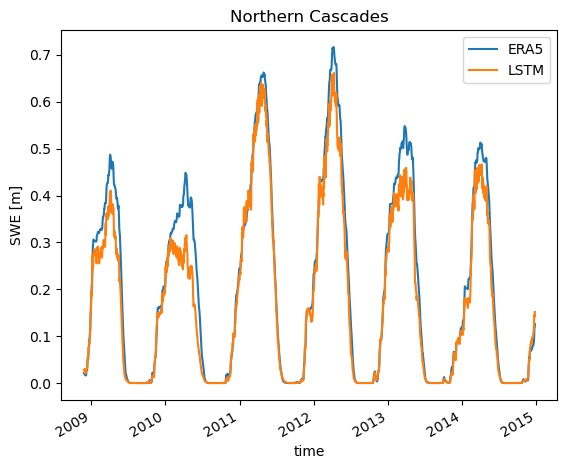

In [12]:
loc = {'lat': slice(49, 47), 'lon': slice(238, 240), }
swe_true.sel(**loc).mean(dim=['lat', 'lon']).plot(label='ERA5')
swe_pred.sel(**loc).mean(dim=['lat', 'lon']).plot(label='LSTM')
plt.title('Northern Cascades')
plt.ylabel('SWE [m]')
plt.legend()

Finally, let's check out results from the Central Sierra Nevada mountains. This particular location has significantly less snow than the Northern Cascades, and even has some low snow years to compare to. From this we can see that the model does quite well with the low snow years, showing strong robustness across different snow regimes.

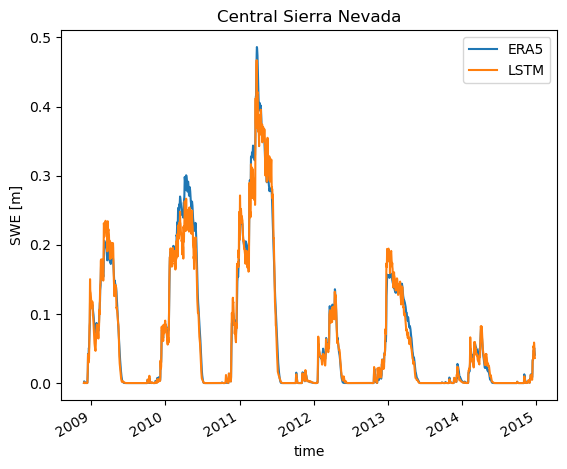

In [13]:
loc = {'lat': slice(38.5, 37.5), 'lon': slice(239.75, 240.25), }
loc_swe_true = swe_true.sel(**loc).mean(dim=['lat', 'lon'])
loc_swe_true.plot(label='ERA5')
loc_swe_pred = swe_pred.sel(**loc).mean(dim=['lat', 'lon'])
loc_swe_pred.plot(label='LSTM')
plt.title('Central Sierra Nevada')
plt.ylabel('SWE [m]')
plt.legend()

The individual SWE traces looked quite good for all of the regions, but the next question to ask is how does the model fare spatially? We will look into this by looking at the peak SWE for about a year's worth of time. First, let's look at the target values, and note the non-linear color scale. The spatial patterns are as expected, with higher snow in the major mountain ranges, and less in low-lying areas.

Text(0.5, 1.0, 'Peak SWE (ERA5)')

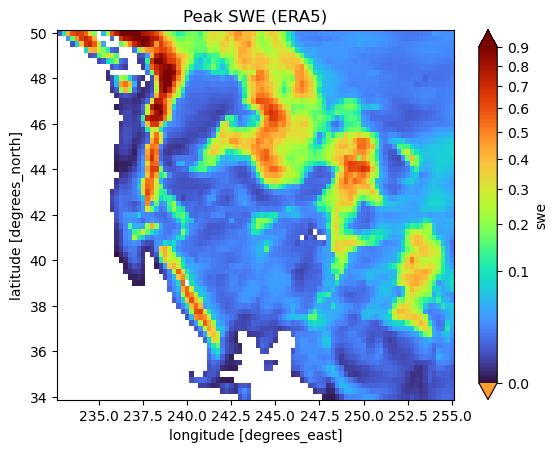

In [14]:
peak_swe = swe_true.isel(time=slice(120, 400)).max(dim='time')
peak_swe = peak_swe.where(true_mask==1, drop=True)

peak_swe.plot(norm=PowerNorm(gamma=0.5, vmin=1e-9, vmax=0.9), cmap='turbo')
plt.title('Peak SWE (ERA5)')

But how does it compare with the peak SWE from our model over the same time period? From the eye, quite well! Below you see these results, and most people would be hard pressed to point out major divergences.

Text(0.5, 1.0, 'Peak SWE (LSTM)')

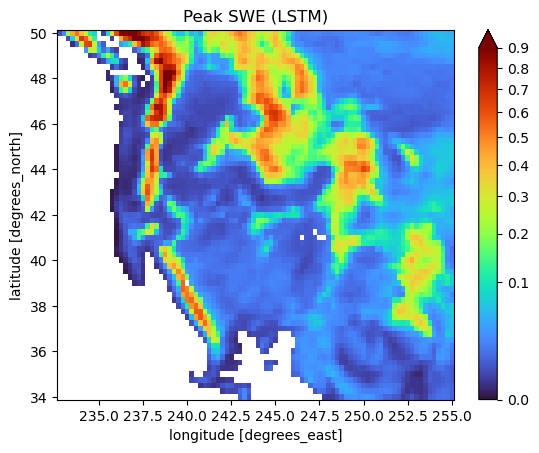

In [15]:
peak_swe = swe_pred.isel(time=slice(120, 400)).max(dim='time')
peak_swe = peak_swe.where(true_mask, drop=True)

peak_swe.plot(norm=PowerNorm(gamma=0.5, vmin=1e-9, vmax=0.9), cmap='turbo')
plt.title('Peak SWE (LSTM)')

To zoom in a bit better on where model differences crop up, let's also look at an error plot for the two calculations. Overall, we see mostly errors in the mountainous regions where snow predictions are higher, which is in line with what we saw from the timeseries plots and common sense. Overally, the SWE along the coastal regions such as the western slopes of the Cascades and Sierra Nevada mountains are where we have the highest error. It's difficult to say whether this is a structural error in our model/data without training more robustly, but eoverall these results are quite impressive given how much computation muscle we've thrown at the problem!

Text(0.5, 1.0, 'Difference in peak SWE (ERA5-LSTM)')

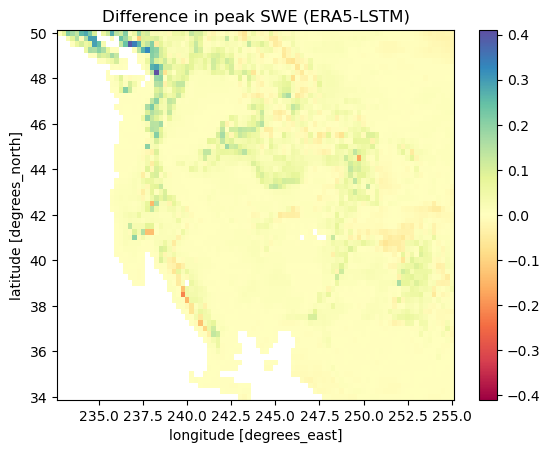

In [16]:
delta_peak_swe = (swe_true.isel(time=slice(120, 400)).max(dim='time')
                  - swe_pred.isel(time=slice(120, 400)).max(dim='time'))
delta_peak_swe = delta_peak_swe.where(true_mask==1, drop=True)

delta_peak_swe.plot(cmap='Spectral')
plt.title('Difference in peak SWE (ERA5-LSTM)')